# Feature Selection using SHAP

In [1]:
ada_parent_dir = "../"
import sys
sys.path.append(ada_parent_dir)
from ada import root_to_df, filter_region, filter_tag, drop_fakes, drop_twodim
import pandas as pd
import numpy as np
import lightgbm as lgb
import warnings


Welcome to JupyROOT 6.16/00


/Users/rpezoa/opt/anaconda3/envs/my_root_env/lib/python3.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.17.2 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)
Using TensorFlow backend.
/Users/rpezoa/opt/anaconda3/envs/my_root_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/rpezoa/opt/anaconda3/envs/my_root_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/rpezoa/opt/anaconda3/envs/my

In [2]:
data_path = "../processed_data/"
signal = "Xtohh2000_Hw"
region = "SR"
tag=2

In [3]:
df_csv = pd.read_csv(data_path+"Xtohh2000.csv")
df_csv =  filter_region(df_csv,region )
df_csv = filter_tag(df_csv, tag)
df_csv["m_region"].value_counts()
df_csv
y = df_csv["sample"] == signal
display(df_csv.head())
df_csv.columns

,sample,EventWeightNoXSec,EventWeight,EventNumber,m_region,m_FJNbtagJets,m_AntiBTag,m_AntiTauTag,m_FJpt,m_FJeta,...,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt,m_hhm_Coll,m_hhm_Eff,m_hhm_ConEff,m_hhm_ConVis
0,Xtohh2000_Hw,0.008301,0.001020,46746,SR,2,3,0,885.55927,0.104927,...,3.105514,3.216185,-0.192894,237.88724,1631.6702,263.697630,-999.0,1896.5974,1193.0669,1973.7532
4,Xtohh2000_Hw,0.009094,0.001117,47033,SR,2,2,0,855.69904,0.313113,...,2.779941,2.848176,-0.019178,485.03333,1293.4028,463.512360,-999.0,1832.4620,1597.4098,1934.0298
15,Xtohh2000_Hw,0.007525,0.000925,47483,SR,2,3,0,552.47845,-0.702952,...,3.122708,3.566858,-0.742126,104.55922,1659.8483,80.008150,-999.0,1759.5939,1056.4438,2125.3684
18,Xtohh2000_Hw,0.009422,0.001158,42700,SR,2,2,0,525.10590,-0.941433,...,3.111627,3.282524,-0.130256,166.60722,1075.3092,109.524925,-999.0,1262.3474,1561.9706,1574.2820
20,Xtohh2000_Hw,0.009115,0.001120,43588,SR,2,3,0,916.44147,-0.683193,...,3.079124,3.084862,0.416606,167.35030,1595.7611,244.283460,-999.0,1807.4701,1296.0286,1838.6957


Index(['sample', 'EventWeightNoXSec', 'EventWeight', 'EventNumber', 'm_region',
       'm_FJNbtagJets', 'm_AntiBTag', 'm_AntiTauTag', 'm_FJpt', 'm_FJeta',
       'm_FJphi', 'm_FJm', 'm_DTpt', 'm_DTeta', 'm_DTphi', 'm_DTm',
       'm_DTpt_Eff', 'm_DTeta_Eff', 'm_DTphi_Eff', 'm_DTm_Eff',
       'm_DTpt_ConEff', 'm_DTeta_ConEff', 'm_DTphi_ConEff', 'm_DTm_ConEff',
       'm_DTpt_ConVis', 'm_DTeta_ConVis', 'm_DTphi_ConVis', 'm_DTm_ConVis',
       'm_dPhiFTwDT', 'm_dRFJwDT', 'm_dPhiDTwMET', 'm_MET', 'm_hhm',
       'm_bbttpt', 'm_hhm_Coll', 'm_hhm_Eff', 'm_hhm_ConEff', 'm_hhm_ConVis'],
      dtype='object')

In [4]:
features=['m_FJpt', 
          'm_FJeta', 'm_FJphi', 'm_FJm', 'm_DTpt', 'm_DTeta', 'm_DTphi', 'm_DTm','m_dPhiFTwDT', 
          'm_dRFJwDT', 'm_dPhiDTwMET', 'm_MET', 'm_hhm','m_bbttpt']

In [5]:
df = df_csv[features]

In [6]:
df.head()

,m_FJpt,m_FJeta,m_FJphi,m_FJm,m_DTpt,m_DTeta,m_DTphi,m_DTm,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt
0,885.55927,0.104927,-2.448576,127604.30,623.22710,-0.731510,0.656939,85368.720,3.105514,3.216185,-0.192894,237.88724,1631.6702,263.697630
4,855.69904,0.313113,-1.859287,122862.90,449.37933,-0.306591,0.920655,55754.656,2.779941,2.848176,-0.019178,485.03333,1293.4028,463.512360
15,552.47845,-0.702952,-2.549875,109091.67,631.70496,1.020756,0.610602,76213.550,3.122708,3.566858,-0.742126,104.55922,1659.8483,80.008150
18,525.10590,-0.941433,-1.130162,82382.28,416.48105,0.103909,1.981465,58332.793,3.111627,3.282524,-0.130256,166.60722,1075.3092,109.524925
20,916.44147,-0.683193,1.804695,115936.01,677.16440,-0.495132,-1.274429,94135.960,3.079124,3.084862,0.416606,167.35030,1595.7611,244.283460


In [7]:
import shap
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

##  $X \rightarrow$ data matrix, $Y \rightarrow$ labels vector

In [8]:
X = df.values
Y = y.to_numpy(dtype=int)

## Normalization

In [9]:
mm_scaler = preprocessing.MinMaxScaler()
X_scaled = mm_scaler.fit_transform(df)


print(X_scaled[:,0])

[0.44491035 0.42209011 0.19035826 ... 0.36237799 0.03826124 0.26142278]


## Training data

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size = 0.2)
print(X_train.shape)
print(Y_train.shape)
print(Y_train)

(6989, 14)
(6989,)
18257    True
11515    True
5829     True
27206    True
20071    True
         ... 
2553     True
3010     True
38367    True
41525    True
23060    True
Name: sample, Length: 6989, dtype: bool


In [11]:
X_train

array([[0.31811699, 0.71089709, 0.90876121, ..., 0.39236688, 0.23286674,
        0.30740287],
       [0.29374465, 0.55418907, 0.48212971, ..., 0.16106225, 0.41421925,
        0.14780701],
       [0.3401256 , 0.14315463, 0.89285935, ..., 0.34059997, 0.32776433,
        0.34636284],
       ...,
       [0.17539175, 0.76266609, 0.55819533, ..., 0.22418124, 0.30371792,
        0.17720652],
       [0.43578693, 0.37393624, 0.82242469, ..., 0.23646136, 0.43869919,
        0.15669407],
       [0.29236383, 0.20040939, 0.46065886, ..., 0.09351707, 0.47365882,
        0.19128004]])

In [12]:
random_state = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=random_state)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "random_state": random_state
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.043313


In [13]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(200)
features = df.iloc[select]
features_display = df.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Explainer expected value: [6.26027233]


In [14]:
features_display

,m_FJpt,m_FJeta,m_FJphi,m_FJm,m_DTpt,m_DTeta,m_DTphi,m_DTm,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt
0,885.55927,0.104927,-2.448576,127604.300,623.22710,-0.731510,0.656939,85368.720,3.105514,3.216185,-0.192894,237.88724,1631.6702,263.697630
4,855.69904,0.313113,-1.859287,122862.900,449.37933,-0.306591,0.920655,55754.656,2.779941,2.848176,-0.019178,485.03333,1293.4028,463.512360
15,552.47845,-0.702952,-2.549875,109091.670,631.70496,1.020756,0.610602,76213.550,3.122708,3.566858,-0.742126,104.55922,1659.8483,80.008150
18,525.10590,-0.941433,-1.130162,82382.280,416.48105,0.103909,1.981465,58332.793,3.111627,3.282524,-0.130256,166.60722,1075.3092,109.524925
20,916.44147,-0.683193,1.804695,115936.010,677.16440,-0.495132,-1.274429,94135.960,3.079124,3.084862,0.416606,167.35030,1595.7611,244.283460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093,972.75024,-0.150988,-1.632301,307664.280,651.25305,-0.028114,1.526765,82589.010,3.124119,3.126535,-0.105452,281.94495,1648.2892,321.797850
1104,717.39070,0.498331,-2.102939,36759.336,675.99680,0.390892,1.085450,83201.305,3.094796,3.096660,0.367032,119.65524,1400.5404,52.680850
1105,1168.21960,0.217694,0.407245,433434.900,717.51800,0.199131,-2.821363,69529.910,3.054578,3.054634,-0.077799,435.39540,1912.9319,457.684000
1114,914.82170,-0.539016,1.220560,131930.270,715.48596,0.316485,-2.010238,90303.086,3.052387,3.170008,-0.240535,123.73852,1780.8315,211.990420


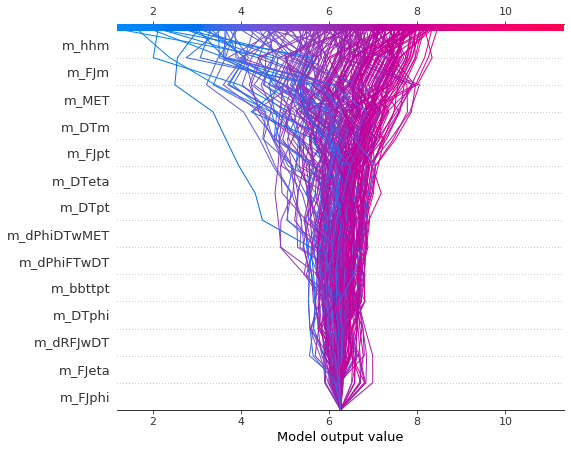

In [15]:
shap.decision_plot(expected_value, shap_values, features_display)


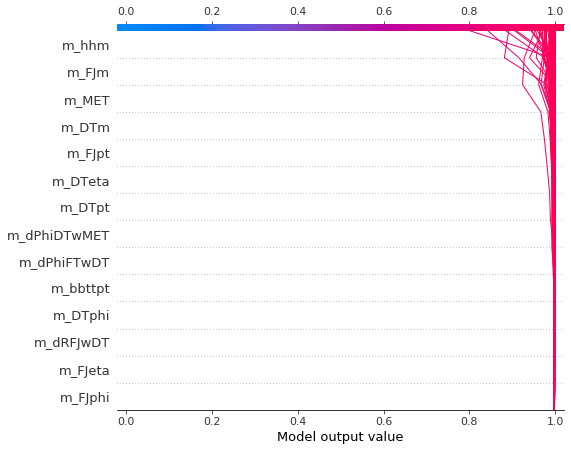

In [16]:
shap.decision_plot(expected_value, shap_values, features_display, link='logit')


In [17]:
#y_test = y_test.values
y_pred = (shap_values.sum(1) + expected_value) > 0

misclassified = y_pred != y_test.values[select]

In [18]:
features_display[misclassified]

,m_FJpt,m_FJeta,m_FJphi,m_FJm,m_DTpt,m_DTeta,m_DTphi,m_DTm,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt
563,723.88495,1.231632,0.232467,121468.516,393.31323,-0.086092,-3.120447,72108.30,2.930271,3.212925,-0.125151,421.403930,1318.4447,349.20600
604,806.57086,-0.604609,1.543650,109639.980,586.62494,-0.298412,-1.587614,67136.87,3.131264,3.146199,0.069752,253.590120,1403.0469,220.06067
669,736.96950,0.650520,-2.800804,84305.050,483.02774,-0.202685,0.229740,84121.76,3.030544,3.148358,-0.009975,234.971250,1313.6589,262.43423
804,911.01263,-0.203608,-2.695235,111582.370,789.57983,0.088828,0.549119,109649.94,3.038832,3.052870,0.380605,30.887266,1726.5056,149.44933
979,884.17650,0.639771,1.697506,110557.410,561.65780,-0.245290,-1.453078,57609.31,3.132602,3.255231,0.120061,288.612200,1558.7618,322.58096


In [19]:
shap_values

array([[ 0.23509509, -0.0043735 , -0.12902368, ...,  0.04713535,
         0.17071771, -0.22013012],
       [ 0.33455776,  0.02858266, -0.01415452, ...,  0.68309791,
        -0.07865278,  0.11088839],
       [-0.31001972,  0.17223278, -0.15600745, ..., -0.83835525,
         0.4271533 , -0.0833839 ],
       ...,
       [-0.0938439 ,  0.04439922,  0.03599933, ...,  0.303293  ,
         0.35913867,  0.06775754],
       [ 0.2155658 , -0.03131295,  0.01042681, ..., -0.32809152,
         1.11496725, -0.01960175],
       [-0.97884123, -0.03249062, -0.01879517, ...,  0.93743141,
        -0.66753171, -0.09021967]])

In [31]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

In [35]:
features_display[misclassified].iloc[0]

m_FJpt             723.884950
m_FJeta              1.231632
m_FJphi              0.232467
m_FJm           121468.516000
m_DTpt             393.313230
m_DTeta             -0.086092
m_DTphi             -3.120447
m_DTm            72108.300000
m_dPhiFTwDT          2.930271
m_dRFJwDT            3.212925
m_dPhiDTwMET        -0.125151
m_MET              421.403930
m_hhm             1318.444700
m_bbttpt           349.206000
Name: 563, dtype: float64

In [38]:
shap_values[0]

array([ 0.23509509, -0.0043735 , -0.12902368,  0.26010604,  0.10183279,
        0.11932554, -0.05453168,  0.34915913, -0.09680008,  0.00292846,
        0.08046466,  0.04713535,  0.17071771, -0.22013012])

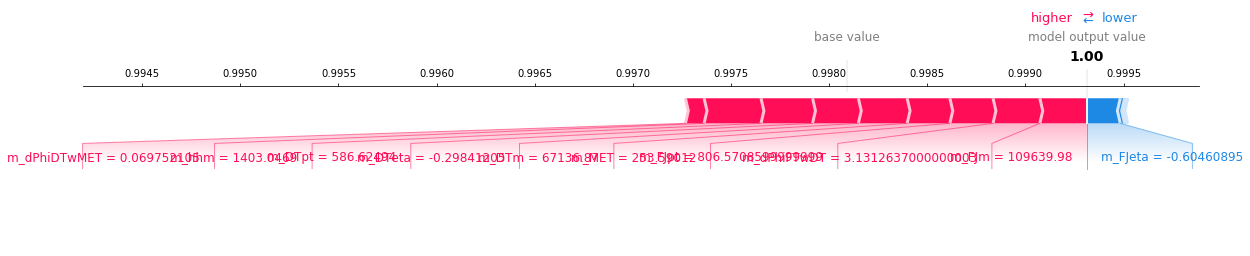

In [40]:
shap.force_plot(expected_value, shap_values[misclassified][1], features_display[misclassified].iloc[1], 
                link='logit', matplotlib=True)

